In [351]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from responsibly.dataset import build_FICO_dataset

FICO = build_FICO_dataset()
get_score = lambda x: 300 + 5.5*x

cost_matrix = np.array([[0.18, 0.],[-0.82,0]])

method = ["Max profit", "Race blind", "Demographic parity", "Equal opportunity", "Equalized odds"]
ethni = FICO["cdf"].columns
Results = {}

In [352]:
def cost_fct(r_fp,r_tp, base_rate, cost_matrix):
    fp = r_fp*(1-base_rate)
    tp = r_tp*base_rate
    tn = 1 - base_rate - fp
    fn = base_rate - tp
    
    return (np.array([tp, fn, fp, tn])*cost_matrix.reshape((4,))).sum()

In [353]:
def max_profit(roc_curves, base_rates, proportions, cost_matrix):
    thresholds = {}
    rates_at_thresholds = {}
    cost = 0
    th = next(iter(roc_curves.values()))[2]
    for grp, roc in roc_curves.items():
        f_cost_by_grp = lambda index: cost_fct(roc[0][index],roc[1][index],base_rates[grp], cost_matrix)
        
        cost_by_th = [f_cost_by_grp(i) for i in range(len(th))]
        threshold_index = np.argmax(cost_by_th)
        rates_at_thresholds[grp] = np.array([roc[0][threshold_index],
                                             roc[1][threshold_index]])
        thresholds[grp] = th[threshold_index]
        cost += f_cost_by_grp(threshold_index)*proportions[grp]
    return thresholds, rates_at_thresholds, cost    

In [354]:
thresholds_max, rates_at_th_max, cost_max = max_profit(FICO["rocs"],FICO["base_rates"],
                                           FICO["proportions"],cost_matrix)
Results[method[0]] = {"thresholds": thresholds_max, "fpr_tpr": rates_at_th_max, "cost": cost_max}

In [355]:
def race_blind(roc_curves, base_rates, proportions, cost_matrix):
    def cost_for_th(index):
        tot_cost = 0
        
        for grp, roc in roc_curves.items():
            tot_cost += (cost_fct(roc[0][index],roc[1][index],
                                 base_rates[grp], cost_matrix)*proportions[grp])
        return tot_cost
        
    th = next(iter(roc_curves.values()))[2]
    cost_by_th = [cost_for_th(i) for i in range(len(th))]
    threshold_index = np.argmax(cost_by_th)
    
    rates_at_thresholds = {grp: np.array([roc[0][threshold_index], 
                                 roc[1][threshold_index]]) 
                           for grp, roc in roc_curves.items()}
    
    cost = cost_for_th(threshold_index)
        
    return th[threshold_index], rates_at_thresholds, cost

In [356]:
thresholds_race_blind, rates_at_th_race_blind, cost_race_blind = race_blind(FICO["rocs"],FICO["base_rates"],
                                           FICO["proportions"],cost_matrix)
Results[method[1]] = {"thresholds": thresholds_race_blind, "fpr_tpr": rates_at_th_race_blind, "cost": cost_race_blind}

In [357]:
def compute_acceptance_rate_indices(roc_curves,base_rates,
                                    acceptance_rate_value):
    indices = {}
    
    for grp, roc in roc_curves.items():
        
        acceptance_rates = np.array(roc[0])*(1-base_rates[grp]) + np.array(roc[1])*base_rates[grp]
        
        assert (np.diff(acceptance_rates) >= 0).all(), ('The acceptance rate is not increasing.')
            
        index = np.argmax(np.concatenate(
            [acceptance_rates>acceptance_rate_value,[1]]), axis = 0)
        
        indices[grp] = index
    
    return indices

In [358]:
def ternary_search(f, x1, x2, tol):
    
    while x2 - x1 > tol:
        x1_ = (2*x1+x2)/3
        x2_ = (x1+2*x2)/3
        if f(x1_) < f(x2_):
            x1 = x1_
        else:
            x2 = x2_
    return (x1+x2)/2

In [359]:

def demographic_parity(roc_curves, base_rates, proportions, 
                       cost_matrix):
    thresholds = {}
    
    tol = 1e-3
    
    def cost_for_acceptance_rate(acceptance_rate_value):
        
        indices = compute_acceptance_rate_indices(roc_curves,base_rates,
                                    acceptance_rate_value)
        
        cost = 0
        
        for grp, roc in roc_curves.items():
            index = indices[grp]
            
            cost_grp = cost_fct(roc[0][index],roc[1][index],
                                base_rates[grp],cost_matrix)
            
            cost += (cost_grp*proportions[grp])
            
        return cost
    
    acceptance_rate_max_cost = ternary_search(cost_for_acceptance_rate,
                                             0,1,tol)
    cost = cost_for_acceptance_rate(acceptance_rate_max_cost)
    th_indices = compute_acceptance_rate_indices(roc_curves,base_rates,
                                    acceptance_rate_max_cost)
    
    th = next(iter(roc_curves.values()))[2]
    
    thresholds = {grp: th[index] for grp, index in th_indices.items()}
    
    rates_at_thresholds = {grp: np.array([roc[0][th_indices[grp]],
                                 roc[1][th_indices[grp]]]) 
                           for grp, roc in roc_curves.items()}
    
    return thresholds, rates_at_thresholds, cost
    

In [360]:
thresholds_demo, rates_at_th_demo, cost_demo = demographic_parity(FICO["rocs"],FICO["base_rates"],
                                           FICO["proportions"],cost_matrix)
Results[method[2]] = {"thresholds": thresholds_demo, "fpr_tpr": rates_at_th_demo, "cost": cost_demo}

# Equal Opportunity

## Achieve Equal Opportunity without randomization

In [361]:
def compute_tpr_indices(roc_curves, tpr):
    indices = {}
    
    for grp, roc in roc_curves.items():
        
        index = np.argmax(np.concatenate(
            [roc[1]>tpr,[1]]), axis = 0) 
        index = max(0,index)
        indices[grp] = index
        
    return indices

def compute_tpr_indices_norm_max(roc_curves, tpr):
    indices = {}
    
    for grp, roc in roc_curves.items():
        
        index = np.argmax(np.concatenate(
            [roc[1]>=tpr,[1]]), axis = 0) 
        index = index - np.argmin(np.array([np.abs(roc[1][index]-tpr),np.abs(roc[1][max(index-1,0)]-tpr)]))
        indices[grp] = max(0,index)
        
    return indices   

In [362]:
def equal_opportunity(roc_curves, base_rates, proportions, 
                       cost_matrix):
    
    thresholds = {}
    tol = 1e-6
    
    def cost_for_tpr(tpr):
        
        indices = compute_tpr_indices_norm_max(roc_curves, tpr)
        cost = 0
        
        for grp, roc in roc_curves.items():
            index = indices[grp]
            
            cost_grp = cost_fct(roc[0][index],roc[1][index],
                               base_rates[grp],cost_matrix)
            cost += (cost_grp*proportions[grp])
            
        return cost
    
    tpr_max_cost = ternary_search(cost_for_tpr, 0, 1, tol)
    
    th_indices = compute_tpr_indices(roc_curves, tpr_max_cost)
    cost = cost_for_tpr(tpr_max_cost)
    
    rates_at_thresholds = {grp: np.array([roc[0][th_indices[grp]],
                                 roc[1][th_indices[grp]]]) 
                           for grp, roc in roc_curves.items()}
    
    th = next(iter(roc_curves.values()))[2]
    
    thresholds = {grp: th[index] for grp, index in th_indices.items()}
    
    return thresholds, rates_at_thresholds, cost, tpr_max_cost
                  

In [363]:
thresholds_opportunity, rates_at_th_opportunity, cost_opportunity, tpr_max_cost = equal_opportunity(FICO["rocs"],FICO["base_rates"],
                                           FICO["proportions"],cost_matrix)
Results[method[3]] = {"thresholds": thresholds_opportunity, "fpr_tpr": rates_at_th_opportunity, "cost": cost_opportunity}

In [364]:
print(tpr_max_cost, rates_at_th_opportunity,cost_opportunity)

0.7543930647218188 {'Asian': array([0.13830821, 0.75972709]), 'Black': array([0.11777864, 0.76588728]), 'Hispanic': array([0.14249461, 0.76051456]), 'White': array([0.08453381, 0.75658316])} 0.07110143161439156


## Achieve Equal Opportunity with randomization

In [365]:
def compute_lower_and_upper_indices(roc_curves, tpr):
    indice = {}
    
    for grp, roc in roc_curves.items():
        
        index_up = np.argmax(np.concatenate(
            [roc[1]>=tpr,[1]]), axis = 0) 
        index_low = np.argmin(np.concatenate(
            [roc[1]<=tpr,[0]]), axis = 0) - 1
        index_low = max(0,index_low)
        
        indice[grp] = np.array([index_low,index_up])
        
    return indice

In [366]:
def equal_opportunity_randomization(roc_curves, base_rates, proportions, 
                       cost_matrix):
    
    thresholds = {}
    tol = 1e-5
    
    def cost_for_tpr(tpr):
        
        cost = 0
        indices = compute_lower_and_upper_indices(roc_curves, tpr)
        
        for grp, roc in roc_curves.items():
                       
            fpr_tpr1 = np.array([roc[0][indices[grp][0]],roc[1][indices[grp][0]]])
            fpr_tpr2 = np.array([roc[0][indices[grp][1]],roc[1][indices[grp][1]]])
            
            if((fpr_tpr1[1] - fpr_tpr2[1]) == 0):
                prob = 1
            else:
                prob = (tpr - fpr_tpr2[1])/(fpr_tpr1[1] - fpr_tpr2[1])
            
            fpr_at_tpr = fpr_tpr1[0]*prob + fpr_tpr2[0]*(1 - prob)
            
            cost_grp = cost_fct(fpr_at_tpr,tpr,
                               base_rates[grp],cost_matrix)
            cost += (cost_grp*proportions[grp])
            
        return cost 
        
    tpr_max_cost = ternary_search(cost_for_tpr, 0, 1, tol)
    
    th_indices = compute_lower_and_upper_indices(roc_curves, tpr_max_cost)
    cost = cost_for_tpr(tpr_max_cost)
    
    rates_at_thresholds_low = {grp: np.array([roc[0][th_indices[grp][0]],
                                 roc[1][th_indices[grp][0]]]) 
                           for grp, roc in roc_curves.items()}
    rates_at_thresholds_up = {grp: np.array([roc[0][th_indices[grp][1]],
                                 roc[1][th_indices[grp][1]]]) 
                           for grp, roc in roc_curves.items()}
    prob = {}
    rates_at_opportunity = {}
    for grp, roc in roc_curves.items():
        fpr_tpr1 = np.array([roc[0][th_indices[grp][0]],roc[1][th_indices[grp][0]]])
        fpr_tpr2 = np.array([roc[0][th_indices[grp][1]],roc[1][th_indices[grp][1]]])

        if((fpr_tpr1[1] - fpr_tpr2[1]) == 0):
            prob[grp] = 1
        else:
            prob[grp] = (tpr_max_cost - fpr_tpr2[1])/(fpr_tpr1[1] - fpr_tpr2[1])

        fpr_at_tpr = fpr_tpr1[0]*prob[grp] + fpr_tpr2[0]*(1 - prob[grp])
        rates_at_opportunity[grp] = np.array([fpr_at_tpr,tpr_max_cost])
    
    thresholds = {grp: np.array([roc[2][th_indices[grp][0]],roc[2][th_indices[grp][1]]]) for grp, roc in roc_curves.items()}
    
    return thresholds, rates_at_thresholds_low, rates_at_thresholds_up, cost, prob, rates_at_opportunity

In [367]:
thresholds_opportunity, rates_at_th_opportunity_low, rates_at_th_opportunity_up, cost_opportunity,prob_opportunity, rates_at_opportunity= equal_opportunity_randomization(FICO["rocs"],
                                                                        FICO["base_rates"],FICO["proportions"],cost_matrix)
thresholds_opportunity

{'Asian': array([45.5, 45. ]),
 'Black': array([29.5, 29. ]),
 'Hispanic': array([34.5, 34. ]),
 'White': array([45.5, 45. ])}

In [368]:
for grp,pdf in FICO["pdf"].items():
    print(pdf[thresholds_opportunity[grp][0]])

0.006599999999999995
0.0037000000000000366
0.006400000000000072
0.005300000000000027


# Equal odds

## Randomization with two threshold

In [369]:
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import scipy as sc

In [370]:
def ternary_search_equalized_odds(f0,f1, tol, x1 = 0, x2 = 1):

    while x2 - x1 > tol:
        x1_ = (2*x1+x2)/3
        x2_ = (x1+2*x2)/3
        if distance_equalized_odds(x1_,f0,f1) < distance_equalized_odds(x2_,f0,f1):
            x2 = x2_
        else:
            x1 = x1_
    return (x1+x2)/2

def distance_equalized_odds(x, f0, f1):
    est =  x*f0 + (1-x)*f1 - np.array(rates_at_th_equal).reshape((2,))
    return np.linalg.norm(est,ord=np.inf)


In [371]:
def compute_randomized_thresholds(roc, fpr, tpr):
    tol = 1e-12
    
    if(in_roc_curve(roc,fpr,tpr,tol)):
        return {"f_opt": np.array([fpr,tpr]), "threshold": roc[2,np.argwhere(np.abs(roc[0]-fpr)<tol)],"fnr_tpr_opt": np.array([fpr,tpr])}
    
    roc_f0 = roc[:,[all([roc[0][i]<=fpr, roc[1][i]<=tpr]) for i in range(np.shape(roc[0])[0])]]
    roc_f1 = roc[:,[all([roc[0][i]>=fpr, roc[1][i]>=tpr]) for i in range(np.shape(roc[0])[0])]]
    
    n0 = np.shape(roc_f0)[1]
    n1 = np.shape(roc_f1)[1]
    
    f0_opt = np.zeros(2)
    f1_opt = np.zeros(2)
    
    dist_opt = 100
    
    score0_opt = 0
    score1_opt = 0
    
    prob_opt = 0
    fnr_tpr_opt = np.zeros(2)
    
    for i in range(n0):
        for j in range(n1):
            f0 = roc_f0[:2,i].reshape((2,))
            score0 = roc_f0[2,i]
            
            f1 = roc_f1[:2,j].reshape((2,))
            score1 = roc_f1[2,j]
            
            x_prob = ternary_search_equalized_odds(f0,f1,tol)
            dist = np.linalg.norm(x_prob*f0 + (1-x_prob)*f1 - np.array([fpr,tpr]).reshape((2,)),ord=np.inf)
            
            if (dist_opt>dist):
                f0_opt = f0
                f1_opt = f1
                score0_opt = roc_f0[2,i]
                score1_opt = roc_f1[2,j]
                prob_opt = x_prob
                dist_opt = dist
                fnr_tpr_opt = prob_opt*f0 + (1-prob_opt)*f1
                
    return {"f0_opt": f0_opt, "f1_opt":f1_opt,"threshold": np.array([score0_opt,score1_opt]),
            "dist_opt":dist_opt,"prob_opt":prob_opt, "fnr_tpr_opt":fnr_tpr_opt }         

In [372]:
thresholds_equal = {}
for grp, roc in FICO["rocs"].items():
    thresholds_equal[grp] = compute_randomized_thresholds(np.array(roc),rates_at_th_equal[0],rates_at_th_equal[1])

In [373]:
thresholds_equal

{'Asian': {'f0_opt': array([0.07110699, 0.58457671]),
  'f1_opt': array([0.12034016, 0.72312863]),
  'threshold': array([57., 48.]),
  'dist_opt': 1.2773033964963432e-06,
  'prob_opt': 0.023927357549735587,
  'fnr_tpr_opt': array([0.11916214, 0.71981345])},
 'Black': {'f0_opt': array([0.08626643, 0.70350961]),
  'f1_opt': array([0.62935847, 0.97266949]),
  'threshold': array([32.5,  8. ]),
  'dist_opt': 9.393345002939313e-07,
  'prob_opt': 0.939428216266698,
  'fnr_tpr_opt': array([0.11916248, 0.71981311])},
 'Hispanic': {'f_opt': array([0.11916342, 0.71981217]),
  'threshold': array([[37.]]),
  'fnr_tpr_opt': array([0.11916342, 0.71981217])},
 'White': {'f0_opt': array([0.02258374, 0.44333939]),
  'f1_opt': array([0.17538008, 0.88084792]),
  'threshold': array([72. , 34.5]),
  'dist_opt': 1.7629725263867968e-05,
  'prob_opt': 0.3680342511699461,
  'fnr_tpr_opt': array([0.11914579, 0.7198298 ])}}

## Randomized with three thresholds

In [374]:
def interieur_triangle(p1,p2,p3,p):
        p1_ = p1 - p
        p2_ = p2 - p
        p3_ = p3 - p
        
        p1_ = p1_/np.linalg.norm(p1_)
        p2_ = p2_/np.linalg.norm(p2_)
        p3_ = p3_/np.linalg.norm(p3_)
        
        theta1 = np.arccos((p1_*p2_).sum())
        theta2 = np.arccos((p2_*p3_).sum())
        theta3 = np.arccos((p3_*p1_).sum())
        
        theta1 = min(theta1,2*np.pi-theta1)
        theta2 = min(theta2,2*np.pi-theta2)
        theta3 = min(theta3,2*np.pi-theta3)
        
        if(theta1+theta2+theta3==2*np.pi):
            return True
        else: 
            return False

def compute_threshold_prob(p0, p1, p2, fpr, tpr):
    a = np.array([[p0[0]-p2[0],p1[0]-p2[0]],[p0[1]-p2[1],p1[1]-p2[1]]])
    b = np.array([fpr-p2[0],tpr-p2[1]])
    x = sc.linalg.solve(a, b)
    prob = np.array([x[0],x[1],1-x[0]-x[1]])
    return prob

def in_roc_curve(roc,fpr,tpr,tol=1e-10):
    i = np.argwhere(np.abs(roc[0]-fpr)<tol)
    j = np.argwhere(np.abs(roc[1] - tpr)<tol)
    if (j.size>0 and i.size>0 and(i[[0]] == j[[0]])):
        return True
    else:
        return False
    

In [375]:
def compute_randomized_thresholds_3(roc, fpr, tpr, pdf,perf):
    tol = 1e-12
    
    roc_f0 = roc[:,[all([roc[0][i]<=fpr, roc[1][i]<=tpr]) for i in range(np.shape(roc[0])[0])]]
    roc_f1 = roc[:,[all([roc[0][i]>fpr, roc[1][i]>tpr]) for i in range(np.shape(roc[0])[0])]]
    
    def randomization_prob_(p1,p2):
        index1 = np.argwhere(roc[0] == p1[0])[0,0]
        index2 = np.argwhere(roc[0] == p2[0])[0,0]
        
        if (index1 == index2):
            return 0
        
        return pdf[index1+1:index2].sum()
    
    def compute_two_th(tol = 1e-16):
        index_f0 = []
        index_f1 = []
        prob_ = 1
        achieve_two_th = False
        
        for i in range(np.shape(roc_f0[0])[0]):
            for j in range(np.shape(roc_f1[0])[0]):
                if(np.abs((fpr-roc_f1[0,j])*(roc_f0[1,i]-roc_f1[1,j]) - (tpr-roc_f1[1,j])*(roc_f0[0,i]-roc_f1[0,j]))<tol):
                    achieve_two_th = True
                    if(prob_ > randomization_prob_(roc_f0[0:2,i],roc_f1[0:2,j])):
                        index_f0 = i
                        index_f1 = j
                        prob_ = randomization_prob_(roc_f0[0:2,i],roc_f1[0:2,j])
        return [achieve_two_th,{"f0_opt": roc_f0[0:2,index_f0],"f1_opt": roc_f1[0:2,index_f1], 
                "score": np.array([roc_f0[2,index_f0],roc_f1[2,index_f1]]), "prob": prob_}]
                
    
    if(in_roc_curve(roc,fpr,tpr,tol)):
        return {"f_opt": np.array([fpr,tpr]), "score": roc[2,np.argwhere(np.abs(roc[0]-fpr)<tol)]}
    achieve, result_achieved = compute_two_th()
    if achieve:
        return result_achieved
         
    def nondefaulter_randomization_prob_(p0,p1,p2):
        vol = ConvexHull([p0,p1,p2]).volume
        return vol
        
    rand_prob = 1
    volume = 1
    th0 = {"fpr": 0, "tpr": 0, "score": 0}
    th1 = {"fpr": 0, "tpr": 0, "score": 0}
    th2 = {"fpr": 0, "tpr": 0, "score": 0}
    
    for i in range(np.shape(roc_f0)[1]-1,-1,-1):
        i_index = np.argwhere(roc[2] == roc_f0[2,i])[0,0]
        
        for j in range(np.shape(roc_f1)[1]):
            j_index = np.argwhere(roc[2] == roc_f1[2,j])[0,0]
            
            roc_f2 = roc[:,i_index+1:j_index]
            prob = randomization_prob_(roc_f0[0:2,i],roc_f1[0:2,j])
            if(prob>rand_prob):
                continue
            elif(prob<=rand_prob):
                for k in range(np.shape(roc_f2)[1]):

                    if(not interieur_triangle(roc_f0[0:2,i],roc_f1[0:2,j],roc_f2[0:2,k],np.array([fpr,tpr]))):
                        continue
                    elif(prob<rand_prob):
                        rand_prob = prob
                        volume = nondefaulter_randomization_prob_(roc_f0[0:2,i],roc_f1[0:2,j],roc_f2[0:2,k])
                        th0 = {"fpr": roc_f0[0,i], "tpr": roc_f0[1,i], "score": roc_f0[2,i]}
                        th1 = {"fpr": roc_f1[0,j], "tpr": roc_f1[1,j], "score": roc_f1[2,j]}
                        th2 = {"fpr": roc_f2[0,k], "tpr": roc_f2[1,k], "score": roc_f2[2,k]}
                    elif(prob==rand_prob):
                        vol = nondefaulter_randomization_prob_(roc_f0[0:2,i],roc_f1[0:2,j],roc_f2[0:2,k])
                        if(vol<volume):
                            volume = vol
                            th0 = {"fpr": roc_f0[0,i], "tpr": roc_f0[1,i], "score": roc_f0[2,i]}
                            th1 = {"fpr": roc_f1[0,j], "tpr": roc_f1[1,j], "score": roc_f1[2,j]}
                            th2 = {"fpr": roc_f2[0,k], "tpr": roc_f2[1,k], "score": roc_f2[2,k]}
                                
    
    prob_pi = compute_threshold_prob(np.array([th0["fpr"],th0["tpr"]]), np.array([th1["fpr"],th1["tpr"]]), 
                                     np.array([th2["fpr"],th2["tpr"]]), fpr, tpr)
    
    result = {"f0_opt": np.array([th0["fpr"],th0["tpr"]]), "f1_opt": np.array([th1["fpr"],th1["tpr"]]),
             "f2_opt": np.array([th2["fpr"],th2["tpr"]]), "score": np.array([th0["score"],th1["score"],th2["score"]]),
             "prob": prob_pi, "randomisation_prob": rand_prob, "volume_Conexhull": volume}
    return result

In [376]:
thresholds_equal_3th = {}
for grp, roc in FICO["rocs"].items():
    roc = np.array(FICO["rocs"][grp])
    pdf = np.array(FICO["pdf"][grp])
    perf = np.array(FICO["performance"][grp])
    result = compute_randomized_thresholds_3(roc, rates_at_th_equal[0],rates_at_th_equal[1], pdf, perf)
    thresholds_equal_3th[grp] = result
    

In [377]:
thresholds_equal_3th


{'Asian': {'f0_opt': array([0.10333706, 0.68444008]),
  'f1_opt': array([0.1278317 , 0.73881061]),
  'f2_opt': array([0.1231253 , 0.72903065]),
  'score': array([51. , 47. , 47.5]),
  'prob': array([0.28401964, 0.35236469, 0.36361567]),
  'randomisation_prob': 0.0398,
  'volume_Conexhull': 8.166263909297625e-06},
 'Black': {'f0_opt': array([0.05999989, 0.62960251]),
  'f1_opt': array([0.21473214, 0.86149328]),
  'f2_opt': array([0.17204569, 0.83094899]),
  'score': array([36.5, 22.5, 25. ]),
  'prob': array([0.60489925, 0.34891988, 0.04618087]),
  'randomisation_prob': 0.03920000000000001,
  'volume_Conexhull': 0.002586203450018278},
 'Hispanic': {'f_opt': array([0.11916342, 0.71981217]),
  'score': array([[37.]])},
 'White': {'f0_opt': array([0.04048664, 0.59067487]),
  'f1_opt': array([0.2504148 , 0.92802519]),
  'f2_opt': array([0.04177892, 0.59843597]),
  'score': array([59.5, 29. , 59. ]),
  'prob': array([0.15223707, 0.37184992, 0.47591301]),
  'randomisation_prob': 0.2974,
  'vo

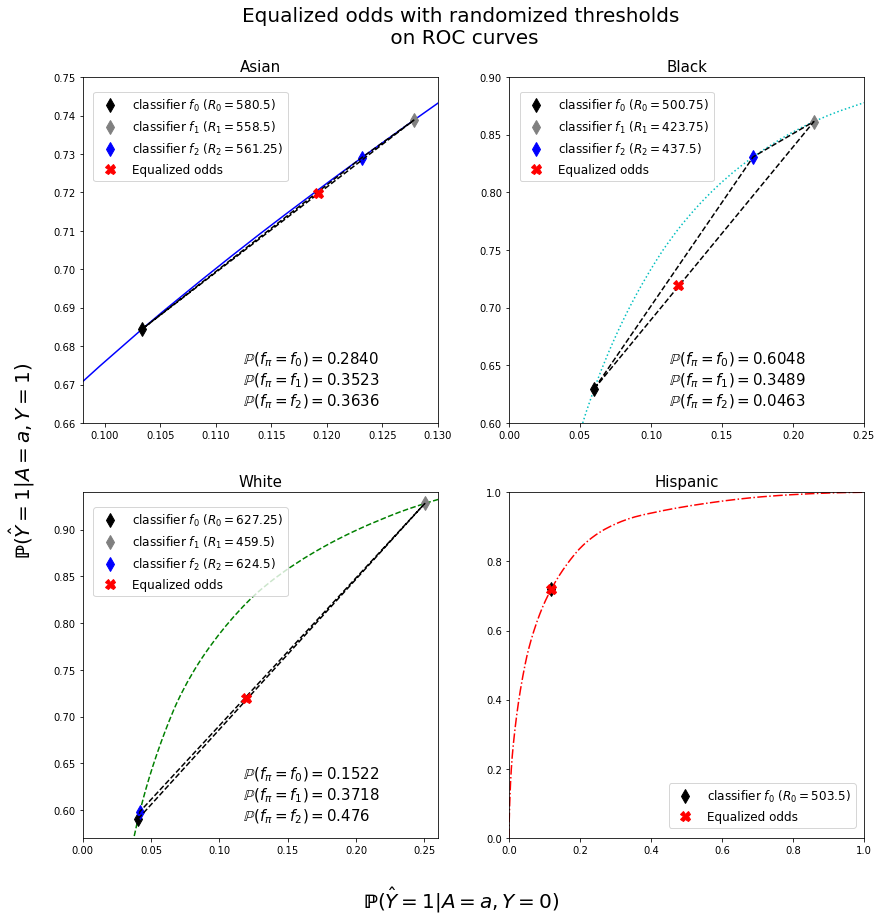

In [379]:
rocs = FICO["rocs"]

colname = list(FICO["cdf"].columns)
color = list(['b','c','r','g'])
linestyle = list(['-',':','-.','--'])

f = lambda x: 300 + 5.5*x
fig, ax = plt.subplots(2,2,figsize=(14,14))

fig.suptitle("Equalized odds with randomized thresholds\n on ROC curves",fontsize=20,y = 0.95)

ax[0,0].plot(rocs[colname[0]][0],rocs[colname[0]][1],color = color[0],linestyle=linestyle[0])
ax[0,1].plot(rocs[colname[1]][0],rocs[colname[1]][1],color = color[1],linestyle=linestyle[1]) 
ax[1,1].plot(rocs[colname[2]][0],rocs[colname[2]][1],color = color[2],linestyle=linestyle[2]) 
ax[1,0].plot(rocs[colname[3]][0],rocs[colname[3]][1],color = color[3],linestyle=linestyle[3]) 
## ---

ax[0,0].plot(thresholds_equal_3th[colname[0]]["f0_opt"][0],thresholds_equal_3th[colname[0]]["f0_opt"][1],'k',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_0$ ($R_0 = $"+
             str(get_score(thresholds_equal_3th[colname[0]]["score"][0]))+")")
ax[0,0].plot(thresholds_equal_3th[colname[0]]["f1_opt"][0],thresholds_equal_3th[colname[0]]["f1_opt"][1],'grey',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_1$ ($R_1 = $"+
             str(get_score(thresholds_equal_3th[colname[0]]["score"][1]))+")")
ax[0,0].plot(thresholds_equal_3th[colname[0]]["f2_opt"][0],thresholds_equal_3th[colname[0]]["f2_opt"][1],'b',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_2$ ($R_2 = $"+
             str(get_score(thresholds_equal_3th[colname[0]]["score"][2]))+")")
ax[0,0].plot([thresholds_equal_3th[colname[0]]["f0_opt"][0],thresholds_equal_3th[colname[0]]["f1_opt"][0],
              thresholds_equal_3th[colname[0]]["f2_opt"][0],thresholds_equal_3th[colname[0]]["f0_opt"][0]],
             [thresholds_equal_3th[colname[0]]["f0_opt"][1],thresholds_equal_3th[colname[0]]["f1_opt"][1],
              thresholds_equal_3th[colname[0]]["f2_opt"][1],thresholds_equal_3th[colname[0]]["f0_opt"][1]],'k--') 

ax[0,0].set_xlim(0.098,0.13)
ax[0,0].set_ylim(0.66,0.75)

ax[0,0].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rX',markersize = 10, label = 'Equalized odds')
ax[0,0].legend(loc = (0.03,0.7),fontsize = 12)
ax[0,0].annotate(r'$\mathbb{P}(f_{\pi} = f_0) = $'+str(thresholds_equal_3th[colname[0]]["prob"][0])[:6]+'\n'
                 +r'$\mathbb{P}(f_{\pi} = f_1) = $'+str(thresholds_equal_3th[colname[0]]["prob"][1])[:6]+'\n'
                 +r'$\mathbb{P}(f_{\pi} = f_2) = $'+
                 str(1-float(str(thresholds_equal_3th[colname[0]]["prob"][0])[:6])-float(str(thresholds_equal_3th[colname[0]]["prob"][1])[:6]))[:6]
                 ,xy=(0.45, 0.05), xycoords='axes fraction',size=15)

## ----

ax[0,1].plot(thresholds_equal_3th[colname[1]]["f0_opt"][0],thresholds_equal_3th[colname[1]]["f0_opt"][1],'k',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_0$ ($R_0 = $"+
             str(get_score(thresholds_equal_3th[colname[1]]["score"][0]))+")")
ax[0,1].plot(thresholds_equal_3th[colname[1]]["f1_opt"][0],thresholds_equal_3th[colname[1]]["f1_opt"][1],'grey',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_1$ ($R_1 = $"+
             str(get_score(thresholds_equal_3th[colname[1]]["score"][1]))+")")
ax[0,1].plot(thresholds_equal_3th[colname[1]]["f2_opt"][0],thresholds_equal_3th[colname[1]]["f2_opt"][1],'b',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_2$ ($R_2 = $"+
             str(get_score(thresholds_equal_3th[colname[1]]["score"][2]))+")")
ax[0,1].plot([thresholds_equal_3th[colname[1]]["f0_opt"][0],thresholds_equal_3th[colname[1]]["f1_opt"][0],
              thresholds_equal_3th[colname[1]]["f2_opt"][0],thresholds_equal_3th[colname[1]]["f0_opt"][0]],
             [thresholds_equal_3th[colname[1]]["f0_opt"][1],thresholds_equal_3th[colname[1]]["f1_opt"][1],
              thresholds_equal_3th[colname[1]]["f2_opt"][1],thresholds_equal_3th[colname[1]]["f0_opt"][1]],'k--') 

ax[0,1].set_xlim(0.0,0.25)
ax[0,1].set_ylim(0.6,0.9)

ax[0,1].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rX',markersize = 10, label = 'Equalized odds')
ax[0,1].legend(loc = (0.03,0.7),fontsize = 12)
ax[0,1].annotate(r'$\mathbb{P}(f_{\pi} = f_0) = $'+str(thresholds_equal_3th[colname[1]]["prob"][0])[:6]+'\n'
                 +r'$\mathbb{P}(f_{\pi} = f_1) = $'+str(thresholds_equal_3th[colname[1]]["prob"][1])[:6]+'\n'
                 +r'$\mathbb{P}(f_{\pi} = f_2) = $'+
                 str(1-float(str(thresholds_equal_3th[colname[1]]["prob"][0])[:6])-float(str(thresholds_equal_3th[colname[1]]["prob"][1])[:6]))[:6]
                 ,xy=(0.45, 0.05), xycoords='axes fraction',size=15)


## ---
ax[1,1].plot(thresholds_equal_3th[colname[2]]["f_opt"][0],thresholds_equal[colname[2]]["f_opt"][1],'k',
             marker='d',linestyle='', markersize = 10,  label=r"classifier $f_0$ ($R_0 = $"+
             str(get_score(thresholds_equal_3th[colname[2]]["score"][0,0]))+")")

ax[1,1].set_xlim(0.,1)
ax[1,1].set_ylim(0.,1)
ax[1,1].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rX',markersize = 10, label = 'Equalized odds')
ax[1,1].legend(loc = (0.45,0.03),fontsize = 12)


## ---

ax[1,0].plot(thresholds_equal_3th[colname[3]]["f0_opt"][0],thresholds_equal_3th[colname[3]]["f0_opt"][1],'k',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_0$ ($R_0 = $"+
             str(get_score(thresholds_equal_3th[colname[3]]["score"][0]))+")")
ax[1,0].plot(thresholds_equal_3th[colname[3]]["f1_opt"][0],thresholds_equal_3th[colname[3]]["f1_opt"][1],'grey',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_1$ ($R_1 = $"+
             str(get_score(thresholds_equal_3th[colname[3]]["score"][1]))+")")
ax[1,0].plot(thresholds_equal_3th[colname[3]]["f2_opt"][0],thresholds_equal_3th[colname[3]]["f2_opt"][1],'b',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_2$ ($R_2 = $"+
             str(get_score(thresholds_equal_3th[colname[3]]["score"][2]))+")")
ax[1,0].plot([thresholds_equal_3th[colname[3]]["f0_opt"][0],thresholds_equal_3th[colname[3]]["f1_opt"][0],
              thresholds_equal_3th[colname[3]]["f2_opt"][0],thresholds_equal_3th[colname[3]]["f0_opt"][0]],
             [thresholds_equal_3th[colname[3]]["f0_opt"][1],thresholds_equal_3th[colname[3]]["f1_opt"][1],
              thresholds_equal_3th[colname[3]]["f2_opt"][1],thresholds_equal_3th[colname[3]]["f0_opt"][1]],'k--') 

ax[1,0].set_xlim(0.0,0.26)
ax[1,0].set_ylim(0.57,0.94)

ax[1,0].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rX',markersize = 10, label = 'Equalized odds')
ax[1,0].legend(loc = (0.03,0.7),fontsize = 12)
ax[1,0].annotate(r'$\mathbb{P}(f_{\pi} = f_0) = $'+str(thresholds_equal_3th[colname[3]]["prob"][0])[:6]+'\n'
                 +r'$\mathbb{P}(f_{\pi} = f_1) = $'+str(thresholds_equal_3th[colname[3]]["prob"][1])[:6]+'\n'
                 +r'$\mathbb{P}(f_{\pi} = f_2) = $'+
                 str(1-float(str(thresholds_equal_3th[colname[3]]["prob"][0])[:6])-float(str(thresholds_equal_3th[colname[3]]["prob"][1])[:6]))[:6]
                 ,xy=(0.45, 0.05), xycoords='axes fraction',size=15)

fig.supxlabel(r'$\mathbf{\mathbb{P}}(\hat{Y} = 1 | A = a, Y = 0)$',y = 0.05,fontsize=20,)
fig.supylabel(r'$\mathbf{\mathbb{P}}(\hat{Y} = 1 | A = a, Y = 1)$',x = 0.05,fontsize=20)
ax[0,0].set_title(colname[0],size=15)
ax[0,1].set_title(colname[1],size = 15)
ax[1,0].set_title(colname[3],size=15)
ax[1,1].set_title(colname[2],size = 15)


plt.savefig("Randomized_threshold_3_th.png", dpi=300, bbox_inches='tight')

## Compute Equal Odds

In [380]:
def intersection_segment(p1,p2,pp1,pp2):
        px= ( (p1[0]*p2[1]-p1[1]*p2[0])*(pp1[0]-pp2[0])-(p1[0]-p2[0])*(pp1[0]*pp2[1]-pp1[1]*pp2[0]) ) / ( (p1[0]-p2[0])*(pp1[1]-pp2[1])-(p1[1]-p2[1])*(pp1[0]-pp2[0]) ) 
        py= ( (p1[0]*p2[1]-p1[1]*p2[0])*(pp1[1]-pp2[1])-(p1[1]-p2[1])*(pp1[0]*pp2[1]-pp1[1]*pp2[0]) ) / ( (p1[0]-p2[0])*(pp1[1]-pp2[1])-(p1[1]-p2[1])*(pp1[0]-pp2[0]) )
        return [px, py]

In [381]:
def equalized_odds(roc_curves, base_rate, proportion,
                       cost_matrix):
       
    result = (-1, None)                
    A_list = list()
    b_list = list()
    
    for grp, roc in roc_curves.items():
        q = ConvexHull(np.array(roc[0:2]).T)
        A_list.append(q.equations[:,:2])
        b_list.append(q.equations[:,2])
    
    A = np.concatenate([a for a in A_list],axis = 0)
    b = - np.concatenate([a for a in b_list],axis = 0)
    c = - np.array([cost_matrix[1,0]*(1-base_rate),cost_matrix[0,0]*base_rate])
    
    lin_opt = sc.optimize.linprog(c, A_ub=A, b_ub=b, method='revised simplex',options ={"tol": 1e-16})
    
    result = (-lin_opt.fun, lin_opt.x)
            
    return result[1], result[0]

In [382]:
rates_at_th_equal, cost_equal = equalized_odds(FICO["rocs"],FICO["base_rate"],FICO["proportions"]
                                               ,cost_matrix)
cost_equal

0.06148316725238567

In [383]:
Results[method[4]] = {"thresholds": thresholds_equal, "fpr_tpr": rates_at_th_equal, "cost": cost_equal}
Results

{'Max profit': {'thresholds': {'Asian': 38.0,
   'Black': 48.0,
   'Hispanic': 45.5,
   'White': 40.0},
  'fpr_tpr': {'Asian': array([0.19455386, 0.84962752]),
   'Black': array([0.02226113, 0.42915052]),
   'Hispanic': array([0.0646744 , 0.58063762]),
   'White': array([0.12141451, 0.82393718])},
  'cost': 0.07644995830821559},
 'Race blind': {'thresholds': 41.0,
  'fpr_tpr': {'Asian': array([0.16989697, 0.81636542]),
   'Black': array([0.04089166, 0.55079517]),
   'Hispanic': array([0.09031287, 0.65672647]),
   'White': array([0.11484788, 0.81389953])},
  'cost': 0.07595318468086208},
 'Demographic parity': {'thresholds': {'Asian': 55.0,
   'Black': 19.5,
   'Hispanic': 33.0,
   'White': 54.0},
  'fpr_tpr': {'Asian': array([0.07959273, 0.61613273]),
   'Black': array([0.31602442, 0.89951936]),
   'Hispanic': array([0.15710574, 0.78285103]),
   'White': array([0.05412432, 0.65949085])},
  'cost': 0.05393631269932833},
 'Equal opportunity': {'thresholds': {'Asian': 45.5,
   'Black': 29

In [384]:
cost_equal_opt = 0
prop = FICO["proportions"]
base_rates = FICO["base_rates"]

for name in colname:
    cost_equal_opt += cost_fct(Results[method[4]]["thresholds"][name]["fnr_tpr_opt"][0],
                               Results[method[4]]["thresholds"][name]["fnr_tpr_opt"][1],
                               base_rates[name],cost_matrix)*prop[name]

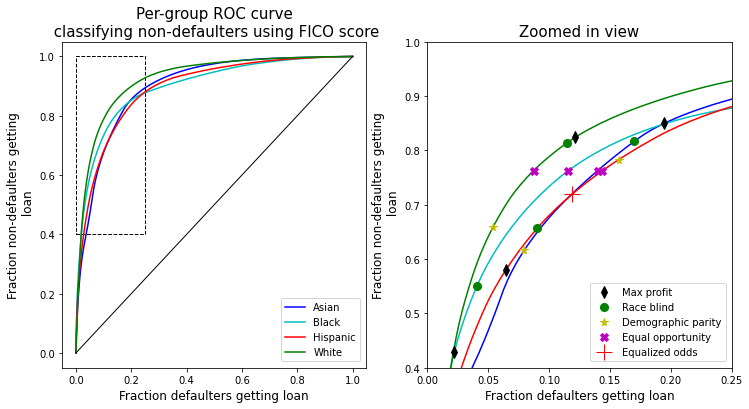

In [385]:
rocs = FICO["rocs"]

colname = list(FICO["cdf"].columns)
color = list(['b','c','r','g'])
linestyle = list(['-','-','-','-'])

f = lambda x: 300 + 5.5*x
fig, ax = plt.subplots(1,2,figsize=(12,6))
i = 0

max_prof = np.zeros((4,2))
race_blind = np.zeros((4,2))
opportunity = np.zeros((4,2))
equal_odds = np.zeros((4,2))
demo_parity = np.zeros((4,2))

for name in colname:
    ax[0].plot(rocs[name][0],rocs[name][1],color = color[i],label = name,linestyle=linestyle[i])
    ax[1].plot(rocs[name][0],rocs[name][1],color = color[i],linestyle=linestyle[i]) 
    max_prof[i,]= rates_at_th_max[name]
    race_blind[i,] = rates_at_th_race_blind[name]
    opportunity[i,] = rates_at_opportunity[name]
    demo_parity[i,] = rates_at_th_demo[name]
    i += 1

ax[1].plot(max_prof[:,0],max_prof[:,1],'kd',markersize = 8, label=method[0]) 
ax[1].plot(race_blind[:,0],race_blind[:,1],'go',markersize = 8, label=method[1]) 
ax[1].plot(demo_parity[:,0],demo_parity[:,1],'y*',markersize = 8, label=method[2]) 
ax[1].plot(opportunity[:,0],opportunity[:,1],'mX',markersize = 8, label=method[3]) 



ax[1].plot(rates_at_th_equal[0],rates_at_th_equal[1],'r+',markersize = 16,label = method[4])
ax[1].legend(loc = (0.535,0.02))
ax[0].legend(loc = (0.72,0.02))
ax[1].set_xlim(0.,0.25)
ax[1].set_ylim(0.4,1)
ax[0].plot(np.array([0,1]),'k',linewidth = 1)
ax[0].yaxis.label.set_size(12)
ax[1].yaxis.label.set_size(12)
ax[0].xaxis.label.set_size(12)
ax[1].xaxis.label.set_size(12)
ax[0].set(xlabel="Fraction defaulters getting loan",ylabel="Fraction non-defaulters getting\n loan")
ax[1].set(xlabel="Fraction defaulters getting loan",ylabel="Fraction non-defaulters getting\n loan")
ax[0].set_title("Per-group ROC curve\n classifying non-defaulters using FICO score",size=15)
ax[1].set_title("Zoomed in view",size = 15)

ax[0].add_patch(plt.Rectangle(np.array([0,0.4]), 0.25,0.6,ls="--", lw=1,
                            ec="k", fc="none"))
#ax[1].quiver(rates_at_th_equal[0],rates_at_th_equal[1], np.array((-0.82*0.1)),np.array((0.18*0.1)),units='xy' ,scale=1)

plt.savefig("slices_Visualisation_of_the_different_rates.png", dpi=1000,bbox_inches='tight')
#plt.savefig("Visualisation_of_the_different_rates.jpeg", dpi=1000,bbox_inches='tight')

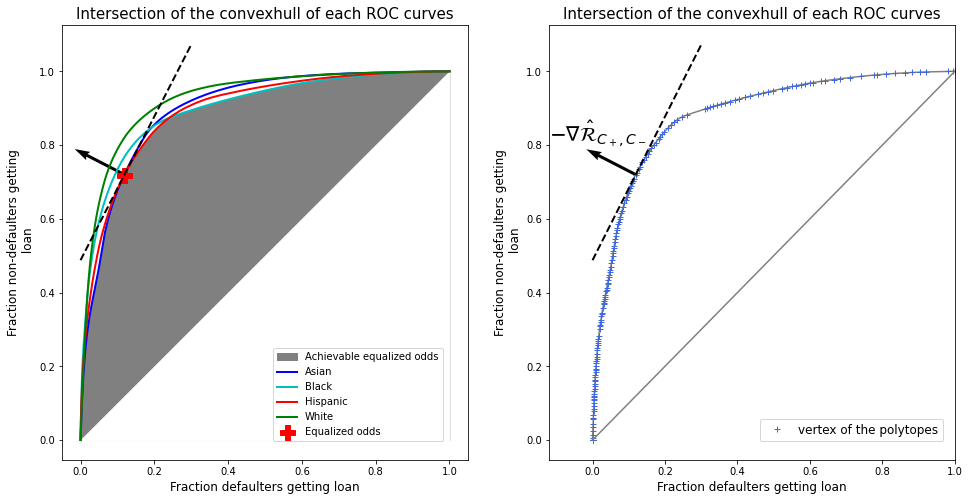

In [386]:
rocs = FICO["rocs"]
base_rate = FICO["base_rate"]
colname = list(FICO["cdf"].columns)
color = list(['b','c','r','g'])
linestyle = list(['-','-','-','-'])

polygons = [Delaunay(list(zip(fprs, tprs)))
                for group, (fprs, tprs, _) in rocs.items()]

feasible_points = []

for poly in polygons:
    for p in poly.points:
        if all(poly2.find_simplex(p) != -1 for poly2 in polygons):
            feasible_points.append(p)
feasible_points = np.array(feasible_points)



f = lambda x: 300 + 5.5*x
fig, ax = plt.subplots(1,2,figsize=(16,8))
i = 0

max_prof = np.zeros((4,2))
race_blind = np.zeros((4,2))
opportunity = np.zeros((4,2))
equal_odds = np.zeros((4,2))
demo_parity = np.zeros((4,2))
ax[0].fill_between(np.sort(feasible_points,axis = 0)[:,0],np.sort(feasible_points,axis = 0)[:,1],color = 'grey',
                label='Achievable equalized odds')
ax[0].fill_between(np.sort(feasible_points,axis = 0)[:,0],np.sort(feasible_points,axis = 0)[:,0],color = 'w')
for name in colname:
    ax[0].plot(rocs[name][0],rocs[name][1],color = color[i],linestyle=linestyle[i],lw = 2,label = name) 
    max_prof[i,]= rates_at_th_max[name]
    race_blind[i,] = rates_at_th_race_blind[name]
    opportunity[i,] = rates_at_th_opportunity[name]
    demo_parity[i,] = rates_at_th_demo[name]
    i += 1

ax[0].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rP',markersize = 15,label = method[4])
scale = 0.55
ax[0].quiver(rates_at_th_equal[0],rates_at_th_equal[1], np.array((-0.82*(1-base_rate)*scale)),
          np.array((0.18*base_rate*scale)),units='xy' ,scale=1)

tangente = lambda x: (0.82*(1-base_rate)/(0.18*base_rate))*(x-rates_at_th_equal[0])+rates_at_th_equal[1]
x = np.linspace(0,0.3,101)

ax[0].plot(x,tangente(x),lw = 2, color = 'k',linestyle='--')

ax[0].legend(loc = (0.52,0.043))
ax[0].yaxis.label.set_size(12)
ax[0].xaxis.label.set_size(12)
ax[0].set(xlabel="Fraction defaulters getting loan",ylabel="Fraction non-defaulters getting\n loan")
ax[0].set_title("Intersection of the convexhull of each ROC curves",size = 15)

ax[1].plot(np.sort(feasible_points,axis = 0)[:,0],np.sort(feasible_points,axis = 0)[:,1],color='grey')
ax[1].plot(np.sort(feasible_points,axis = 0)[:,0],np.sort(feasible_points,axis = 0)[:,1],marker='+',
           color='royalblue',linestyle='',label = 'vertex of the polytopes')
ax[1].plot(np.array([0,1]),np.array([0,1]),color='grey')
scale = 0.55
ax[1].quiver(rates_at_th_equal[0],rates_at_th_equal[1], np.array((-0.82*(1-base_rate)*scale)),
          np.array((0.18*base_rate*scale)),units='xy' ,scale=1)

ax[1].text(-0.12, 0.81, r'$\minus \nabla \hat{\mathcal{R}}_{C_+,C_-}$', fontsize=20)
ax[1].set_xlim(-0.12,1.)
#ax[1].set_ylim(0.4,1)

ax[1].plot(x,tangente(x),lw = 2, color = 'k',linestyle='--')
ax[1].legend(loc = (0.52,0.043),prop={'size': 12})
ax[1].yaxis.label.set_size(12)
ax[1].xaxis.label.set_size(12)
ax[1].set(xlabel="Fraction defaulters getting loan",ylabel="Fraction non-defaulters getting\n loan")
ax[1].set_title("Intersection of the convexhull of each ROC curves",size = 15)
plt.savefig("computation_equalized_ods.png", dpi=300,bbox_inches='tight')

In [388]:
TP_rates = pd.DataFrame(index=colname, columns=method)

TP_rates[method[0]] = np.array([rates_at_th_max[name][1] for name in colname])
TP_rates[method[1]] = np.array([rates_at_th_race_blind[name][1] for name in colname])
TP_rates[method[2]] = np.array([rates_at_th_demo[name][1] for name in colname])
TP_rates[method[3]] = np.array([rates_at_opportunity[name][1] for name in colname])
TP_rates[method[4]] = np.array([rates_at_th_equal[1] for name in colname])

FP_rates = pd.DataFrame(index=colname, columns=method)

FP_rates[method[0]] = np.array([rates_at_th_max[name][0] for name in colname])
FP_rates[method[1]] = np.array([rates_at_th_race_blind[name][0] for name in colname])
FP_rates[method[2]] = np.array([rates_at_th_demo[name][0] for name in colname])
FP_rates[method[3]] = np.array([rates_at_opportunity[name][0] for name in colname])
FP_rates[method[4]] = np.array([rates_at_th_equal[0] for name in colname])


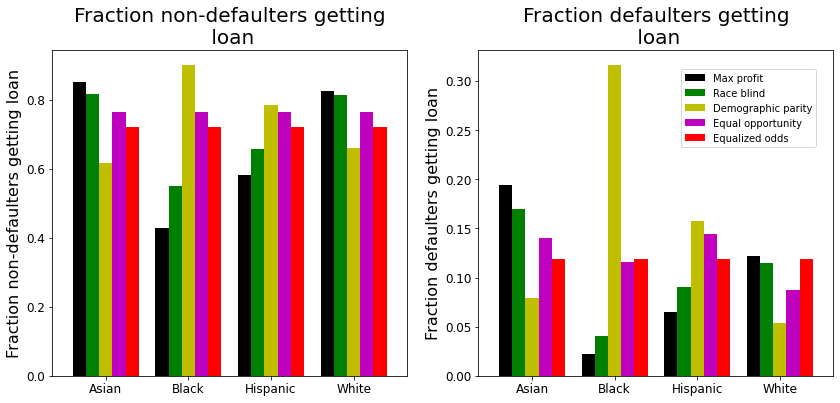

In [391]:
colname = list(FICO["cdf"].columns)
method_slices = ["Max profit","Equal opportunity","Equalized odds"]
fig, ax = plt.subplots(1,2,figsize=(14,6))
TP_rates.plot.bar(color = list(['k','g','y','m','r']),ax = ax[0], rot = 0,fontsize =12 ,legend = None, width = 0.8)
FP_rates.plot.bar(color = list(['k','g','y','m','r']),ax = ax[1],rot = 0,fontsize =12, width = 0.8 )

#TP_rates[method_slices].plot.bar(color = list(['k','g','r']),ax = ax[0], rot = 0,fontsize =12 ,legend = None, width = 0.8)
#FP_rates[method_slices].plot.bar(color = list(['k','g','r']),ax = ax[1],rot = 0,fontsize =12, width = 0.8 )

ax[0].set(ylabel="Fraction non-defaulters getting loan")
ax[1].set(ylabel="Fraction defaulters getting loan")

ax[0].yaxis.label.set_size(16)
ax[1].yaxis.label.set_size(16)
ax[0].xaxis.label.set_size(12)
ax[1].xaxis.label.set_size(12)

ax[0].set_title("Fraction non-defaulters getting\n loan",size=20)
ax[1].set_title("Fraction defaulters getting\n loan",size = 20)

#ax[1].legend(loc = (0.62,0.8))
ax[1].legend(loc = (0.57,0.7))

plt.savefig("slices_Fraction_get_loan.png", dpi=300,bbox_inches='tight')
#plt.savefig("Fraction_get_loan.jpeg", dpi=1000,bbox_inches='tight')

In [392]:
thresholds = pd.DataFrame(index=colname, columns=method[:4])

thresholds[method[0]] = np.array([get_score(thresholds_max[name]) for name in colname])
thresholds[method[1]] = np.array([get_score(thresholds_race_blind) for name in colname])
thresholds[method[2]] = np.array([get_score(thresholds_demo[name]) for name in colname])
#thresholds[method[3]] = np.array([get_score(thresholds_opportunity[name]) for name in colname])
#thresholds[method[4]] = np.array([get_score(thresholds_equal[name]) for name in colname])

thresholds = thresholds.T

In [393]:
thresholds_within_grp = pd.DataFrame(index=colname, columns=method[:4])

In [306]:
thresholds_opportunity


{'Asian': array([45.5, 45. ]),
 'Black': array([29.5, 29. ]),
 'Hispanic': array([34.5, 34. ]),
 'White': array([45.5, 45. ])}

/var/folders/c4/wb13541d4n104gj2c8s0pdf40000gn/T/ipykernel_2490/3354277812.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator


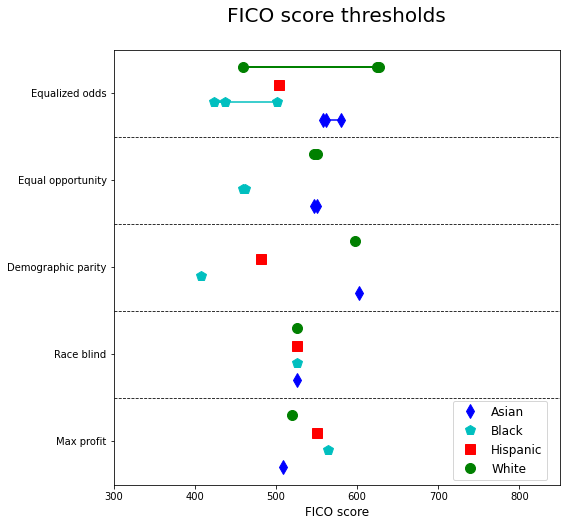

In [394]:
colname = list(FICO["cdf"].columns)
meth = ['', 'Max profit','Race blind','Demographic parity','Equal opportunity','Equalized odds']

fig, ax = plt.subplots(1,1,figsize=(8,8))
#thresholds.plot(y = list(thresholds.columns),color = list(['k','g','y','m','r']),ax = ax[0], rot = 45,fontsize =12 ,legend = None,marker= 'o',linestyle='')
#FP_rates.plot.scatter(color = list(['k','g','y','m','r']),ax = ax[1],rot = 0,fontsize =12, width = 0.8,marker='ko' )
ax.plot(ylim=(-1,5))
ax.set_yticklabels(meth)

for i in range(4):
    ax.axhline(y=1.5 + i,linestyle='dashed',color = 'k', lw = 0.8)

shift = np.linspace(-0.3,0.3,4)
markers = ['d','p','s','o']
col = ['b','c','r','g']
for i in range(4):
    ax.plot(thresholds[colname[i]],np.array([1,2,3,4])+shift[i],linestyle='',marker = markers[i],color=col[i],
            label=colname[i],markersize=10)
    if(colname[i] != "Hispanic"):
        ax.plot(get_score(thresholds_equal_3th[colname[i]]['score']),np.array([5+shift[i],5+shift[i],5+shift[i]]),marker = markers[i],color=col[i],markersize=10)
        ax.plot(get_score(thresholds_opportunity[colname[i]]),np.array([4+shift[i],4+shift[i]]),marker = markers[i],color=col[i],markersize=10)
    else:
        ax.plot(get_score(thresholds_equal_3th[colname[i]]["score"][0,0]),np.array([5+shift[i]]),
                   marker=markers[i],color=col[i],markersize=10)


ax.set(xlabel="FICO score")
#ax.set(xlabel="Within-group FICO score percentile")

ax.yaxis.label.set_size(16)
#ax[1].yaxis.label.set_size(16)
ax.xaxis.label.set_size(12)
#ax[1].xaxis.label.set_size(12)
ax.legend(loc = (0.76,0.01),fontsize=12)
ax.set_title("FICO score thresholds",size=20,y = 1.05)
#ax[1].set_title("FICO score thresholds\n (within-group)",size = 20)
ax.set_ylim((0.5,5.5))
ax.set_xlim((300,850))
#ax[0].legend(loc = (0.5,0.02))
#ax[1].legend(loc = (0.57,0.7))
plt.savefig("Threshold.png", dpi=300, bbox_inches='tight')

In [395]:
thresholds_slices = pd.DataFrame(index=colname, columns=["Max profit", "Equal opportunity"])

thresholds_slices[method[0]] = np.array([get_score(thresholds_max[name]) for name in colname])
thresholds_slices[method[3]] = np.array([get_score(thresholds_opportunity[name]) for name in colname])
#thresholds[method[4]] = np.array([get_score(thresholds_equal[name]) for name in colname])

thresholds_slices = thresholds_slices.T


/var/folders/c4/wb13541d4n104gj2c8s0pdf40000gn/T/ipykernel_2490/2798984486.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator


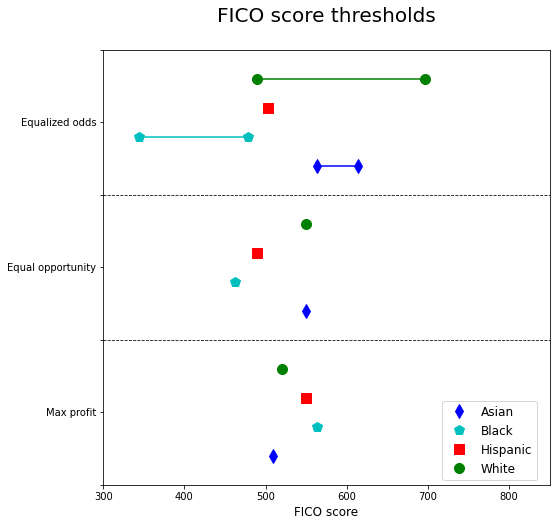

In [396]:
colname = list(FICO["cdf"].columns)
meth = ['', 'Max profit','Equal opportunity','Equalized odds']
meth_label = ['', 'Max profit','','Equal opportunity','','Equalized odds']
fig, ax = plt.subplots(1,1,figsize=(8,8))
#thresholds.plot(y = list(thresholds.columns),color = list(['k','g','y','m','r']),ax = ax[0], rot = 45,fontsize =12 ,legend = None,marker= 'o',linestyle='')
#FP_rates.plot.scatter(color = list(['k','g','y','m','r']),ax = ax[1],rot = 0,fontsize =12, width = 0.8,marker='ko' )
ax.plot(ylim=(-1,3))

ax.set_yticklabels(meth_label)
ax.set_ylim((0.5,3.5))
for i in range(2):
    ax.axhline(y=1.5 + i,linestyle='dashed',color = 'k', lw = 0.8)

shift = np.linspace(-0.3,0.3,4)
markers = ['d','p','s','o']
col = ['b','c','r','g']
for i in range(4):
    ax.plot(thresholds_slices[colname[i]],np.array([1,2])+shift[i],linestyle='',marker = markers[i],color=col[i],
            label=colname[i],markersize=10)
    if(colname[i] != "Hispanic"):
        ax.plot(get_score(thresholds_equal[colname[i]]["threshold"]),np.array([3+shift[i],3+shift[i]]),
                   marker=markers[i],color=col[i],markersize=10)
    else:
        ax.plot(get_score(thresholds_equal[colname[i]]["threshold"]),np.array([3+shift[i]]),
                   marker=markers[i],color=col[i],markersize=10)

ax.set(xlabel="FICO score")
#ax.set(xlabel="Within-group FICO score percentile")

ax.yaxis.label.set_size(16)
#ax[1].yaxis.label.set_size(16)
ax.xaxis.label.set_size(12)
#ax[1].xaxis.label.set_size(12)
ax.legend(loc = (0.76,0.01),fontsize=12)
ax.set_title("FICO score thresholds",size=20,y = 1.05)
#ax[1].set_title("FICO score thresholds\n (within-group)",size = 20)
ax.set_ylim((0.5,3.5))
ax.set_xlim((300,850))
#ax[0].legend(loc = (0.5,0.02))
#ax[1].legend(loc = (0.57,0.7))
plt.savefig("slices_Threshold.jpeg", dpi=1000, bbox_inches='tight')

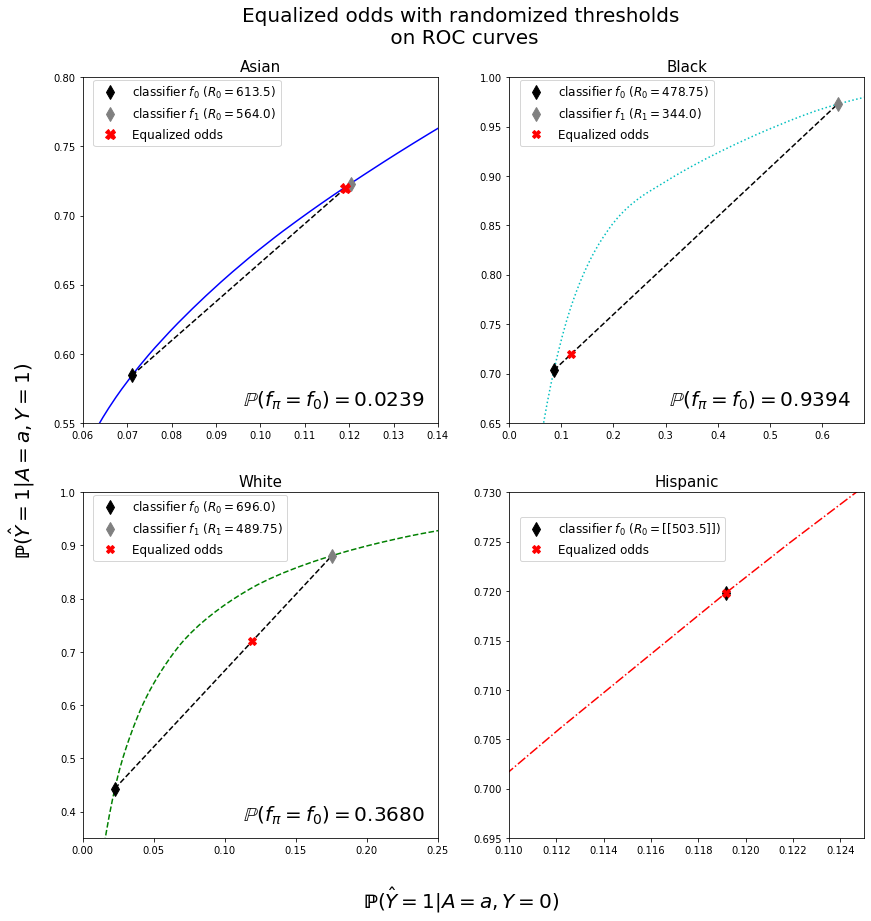

In [310]:
rocs = FICO["rocs"]

colname = list(FICO["cdf"].columns)
color = list(['b','c','r','g'])
linestyle = list(['-',':','-.','--'])

f = lambda x: 300 + 5.5*x
fig, ax = plt.subplots(2,2,figsize=(14,14))

fig.suptitle("Equalized odds with randomized thresholds\n on ROC curves",fontsize=20,y = 0.95)

ax[0,0].plot(rocs[colname[0]][0],rocs[colname[0]][1],color = color[0],linestyle=linestyle[0])
ax[0,1].plot(rocs[colname[1]][0],rocs[colname[1]][1],color = color[1],linestyle=linestyle[1]) 
ax[1,1].plot(rocs[colname[2]][0],rocs[colname[2]][1],color = color[2],linestyle=linestyle[2]) 
ax[1,0].plot(rocs[colname[3]][0],rocs[colname[3]][1],color = color[3],linestyle=linestyle[3]) 
    
ax[0,0].plot([thresholds_equal[colname[0]]["f0_opt"][0],thresholds_equal[colname[0]]["f1_opt"][0]],
             [thresholds_equal[colname[0]]["f0_opt"][1],thresholds_equal[colname[0]]["f1_opt"][1]],'k--') 
ax[0,0].plot(thresholds_equal[colname[0]]["f0_opt"][0],thresholds_equal[colname[0]]["f0_opt"][1],'k',
             marker='d',linestyle='', markersize = 10, label=r"classifier $f_0$ ($R_0 = $"+
             str(get_score(thresholds_equal[colname[0]]["threshold"][0]))+")")
ax[0,0].plot(thresholds_equal[colname[0]]["f1_opt"][0],thresholds_equal[colname[0]]["f1_opt"][1],'grey',
             marker = 'd',linestyle='', markersize = 10, label=r"classifier $f_1$ ($R_0 = $"+
             str(get_score(thresholds_equal[colname[0]]["threshold"][1]))+")")
ax[0,0].set_xlim(0.06,0.14)
ax[0,0].set_ylim(0.55,0.8)
ax[0,0].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rX',markersize = 10, label = 'Equalized odds')
ax[0,0].legend(loc = (0.03,0.8),fontsize = 12)
ax[0,0].annotate(r'$\mathbb{P}(f_{\pi} = f_0) = $'+str(thresholds_equal[colname[0]]["prob_opt"])[:6]
                 ,xy=(0.45, 0.05), xycoords='axes fraction',size=20)
## ----
ax[0,1].plot([thresholds_equal[colname[1]]["f0_opt"][0],thresholds_equal[colname[1]]["f1_opt"][0]],
             [thresholds_equal[colname[1]]["f0_opt"][1],thresholds_equal[colname[1]]["f1_opt"][1]],'k--') 
ax[0,1].plot(thresholds_equal[colname[1]]["f0_opt"][0],thresholds_equal[colname[1]]["f0_opt"][1],'k',
             marker='d',linestyle='', markersize = 10,  label=r"classifier $f_0$ ($R_0 = $"+
             str(get_score(thresholds_equal[colname[1]]["threshold"][0]))+")") 
ax[0,1].plot(thresholds_equal[colname[1]]["f1_opt"][0],thresholds_equal[colname[1]]["f1_opt"][1],'grey',
             marker='d',linestyle='', markersize = 10,  label=r"classifier $f_1$ ($R_1 = $"+
             str(get_score(thresholds_equal[colname[1]]["threshold"][1]))+")")
ax[0,1].set_xlim(0.0,0.68)
ax[0,1].set_ylim(0.65,1)
ax[0,1].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rX',markersize = 8, label = 'Equalized odds')
ax[0,1].legend(loc = (0.03,0.8),fontsize = 12)
ax[0,1].annotate(r'$\mathbb{P}(f_{\pi} = f_0) = $'+str(thresholds_equal[colname[1]]["prob_opt"])[:6]
                 ,xy=(0.45, 0.05), xycoords='axes fraction',size=20)

## ---
ax[1,1].plot(thresholds_equal[colname[2]]["f_opt"][0],thresholds_equal[colname[2]]["f_opt"][1],'k',
             marker='d',linestyle='', markersize = 10,  label=r"classifier $f_0$ ($R_0 = $"+
             str(get_score(thresholds_equal[colname[2]]["threshold"]))+")")
#ax[1,1].plot(thresholds_equal[colname[2]]["f1_opt"][0,0],thresholds_equal[colname[2]]["f1_opt"][0,1],'grey',
 #            marker='d',linestyle='', markersize = 10,  label=r"classifier $f_1$ ($R_1 = $"+
 #            str(get_score(thresholds_equal[colname[2]]["threshold"][1]))+")")
ax[1,1].set_xlim(0.11,0.125)
ax[1,1].set_ylim(0.695,0.73)
ax[1,1].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rX',markersize = 8, label = 'Equalized odds')
ax[1,1].legend(loc = (0.03,0.8),fontsize = 12)
#ax[1,1].annotate(r'$\mathbb{P}(f_{\pi} = f_0) = $'+str(thresholds_equal[colname[2]]["prob_opt"])[:6]
                 #,xy=(0.45, 0.05), xycoords='axes fraction',size=20)

## ---
ax[1,0].plot([thresholds_equal[colname[3]]["f0_opt"][0],thresholds_equal[colname[3]]["f1_opt"][0]],
           [thresholds_equal[colname[3]]["f0_opt"][1],thresholds_equal[colname[3]]["f1_opt"][1]],'k--') 
ax[1,0].plot(thresholds_equal[colname[3]]["f0_opt"][0],thresholds_equal[colname[3]]["f0_opt"][1],'k',
         marker='d',linestyle='', markersize = 10,  label=r"classifier $f_0$ ($R_0 = $"+
             str(get_score(thresholds_equal[colname[3]]["threshold"][0]))+")")
ax[1,0].plot(thresholds_equal[colname[3]]["f1_opt"][0],thresholds_equal[colname[3]]["f1_opt"][1],'grey',
             marker='d',linestyle='', markersize = 10,  label=r"classifier $f_1$ ($R_1 = $"+
             str(get_score(thresholds_equal[colname[3]]["threshold"][1]))+")")
ax[1,0].set_xlim(0.,0.25)
ax[1,0].set_ylim(0.35,1)
ax[1,0].plot(rates_at_th_equal[0],rates_at_th_equal[1],'rX',markersize = 8, label = 'Equalized odds')
ax[1,0].legend(loc = (0.03,0.8),fontsize = 12)
ax[1,0].annotate(r'$\mathbb{P}(f_{\pi} = f_0) = $'+str(thresholds_equal[colname[3]]["prob_opt"])[:6]
                ,xy=(0.45, 0.05), xycoords='axes fraction',size=20)


#ax[0,0].legend(loc = (0.535,0.02))
#ax[0].legend(loc = (0.72,0.02))
fig.supxlabel(r'$\mathbf{\mathbb{P}}(\hat{Y} = 1 | A = a, Y = 0)$',y = 0.05,fontsize=20,)
fig.supylabel(r'$\mathbf{\mathbb{P}}(\hat{Y} = 1 | A = a, Y = 1)$',x = 0.05,fontsize=20)
ax[0,0].set_title(colname[0],size=15)
ax[0,1].set_title(colname[1],size = 15)
ax[1,0].set_title(colname[3],size=15)
ax[1,1].set_title(colname[2],size = 15)


plt.savefig("Randomized_threshold.jpeg", dpi=1000, bbox_inches='tight')

In [311]:
thresholds_equal


{'Asian': {'f0_opt': array([0.07110699, 0.58457671]),
  'f1_opt': array([0.12034016, 0.72312863]),
  'threshold': array([57., 48.]),
  'dist_opt': 1.2773033964963432e-06,
  'prob_opt': 0.023927357549735587,
  'fnr_tpr_opt': array([0.11916214, 0.71981345])},
 'Black': {'f0_opt': array([0.08626643, 0.70350961]),
  'f1_opt': array([0.62935847, 0.97266949]),
  'threshold': array([32.5,  8. ]),
  'dist_opt': 9.393345002939313e-07,
  'prob_opt': 0.939428216266698,
  'fnr_tpr_opt': array([0.11916248, 0.71981311])},
 'Hispanic': {'f_opt': array([0.11916342, 0.71981217]),
  'threshold': array([[37.]]),
  'fnr_tpr_opt': array([0.11916342, 0.71981217])},
 'White': {'f0_opt': array([0.02258374, 0.44333939]),
  'f1_opt': array([0.17538008, 0.88084792]),
  'threshold': array([72. , 34.5]),
  'dist_opt': 1.7629725263867968e-05,
  'prob_opt': 0.3680342511699461,
  'fnr_tpr_opt': array([0.11914579, 0.7198298 ])}}

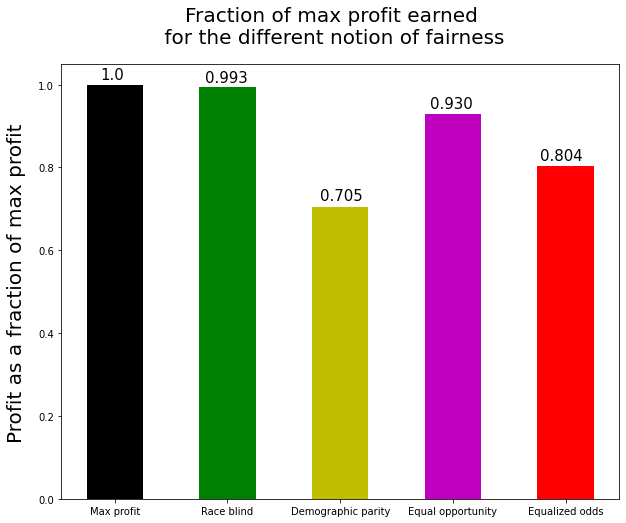

In [399]:
ma = Results[method[0]]['cost']
meth = ['', 'Max profit','Race blind','Demographic parity','Equal opportunity','Equalized odds']
ratio_max_prof = np.array([ma/ma,Results[method[1]]['cost']/ma,Results[method[2]]['cost']/ma,
                           Results[method[3]]['cost']/ma,Results[method[4]]['cost']/ma])

fig = plt.figure(figsize=(10,8))
plt.plot(xlim=(1,5))
plt.bar(meth[1:],ratio_max_prof,color = list(['k','g','y','m','r']),width=0.5)


plt.annotate(str(ratio_max_prof[0])[:5],xy=(0.14, 0.77), xycoords='figure fraction',size=15,color='k')
plt.annotate(str(ratio_max_prof[1])[:5],xy=(0.285, 0.765), xycoords='figure fraction',size=15,color='k')
plt.annotate(str(ratio_max_prof[2])[:5],xy=(0.445, 0.56), xycoords='figure fraction',size=15,color='k')
plt.annotate(str(ratio_max_prof[3])[:5],xy=(0.597, 0.721), xycoords='figure fraction',size=15,color='k')
plt.annotate(str(ratio_max_prof[4])[:5],xy=(0.75, 0.63), xycoords='figure fraction',size=15,color='k')

fig.suptitle("Fraction of max profit earned\n for the different notion of fairness",fontsize=20)
fig.supylabel('Profit as a fraction of max profit',x = 0.05,fontsize=20)

plt.savefig("cost_result.png", dpi=300, bbox_inches='tight')

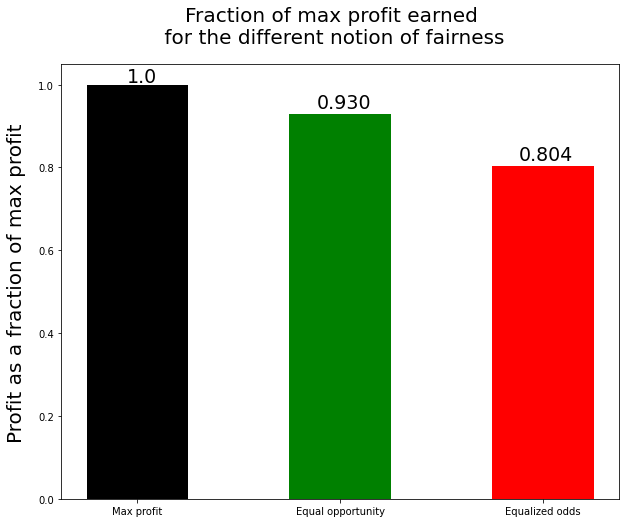

In [313]:
meth = ['', 'Max profit','Equal opportunity','Equalized odds']
ratio_max_prof = np.array([ma/ma,Results[method[3]]['cost']/ma,Results[method[4]]['cost']/ma])

fig = plt.figure(figsize=(10,8))
plt.plot(xlim=(1,5))
plt.bar(meth[1:],ratio_max_prof,color = list(['k','g','r']),width=0.5)


plt.annotate(str(ratio_max_prof[0])[:5],xy=(0.176, 0.765), xycoords='figure fraction',size=19,color='k')
plt.annotate(str(ratio_max_prof[1])[:5],xy=(0.44, 0.721), xycoords='figure fraction',size=19,color='k')
plt.annotate(str(ratio_max_prof[2])[:5],xy=(0.72, 0.63), xycoords='figure fraction',size=19,color='k')

fig.suptitle("Fraction of max profit earned\n for the different notion of fairness",fontsize=20)
fig.supylabel('Profit as a fraction of max profit',x = 0.05,fontsize=20)

plt.savefig("slices_cost_result.jpeg", dpi=1000, bbox_inches='tight')

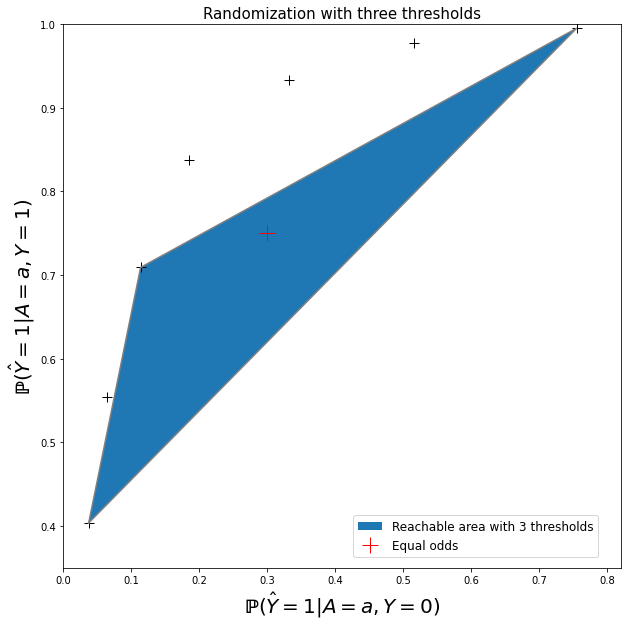

In [44]:
rocs = FICO["rocs"]
feasible_points = rocs["Asian"][:2]

fig, ax = plt.subplots(1,1,figsize=(10,10))
dd = np.array([1,20,40,60,80,100,120,140,160,180,198])
#ax.plot(np.sort(feasible_points,axis = 0)[0,dd],np.sort(feasible_points,axis = 0)[1,dd],color='k')
ax.plot(np.sort(feasible_points,axis = 0)[0,dd],np.sort(feasible_points,axis = 0)[1,dd],marker='+',
           color='k',markersize = 10,linestyle='')


th0 = np.sort(feasible_points,axis = 0)[:,dd[3]]
th1 = np.sort(feasible_points,axis = 0)[:,dd[9]]
th2 = np.sort(feasible_points,axis = 0)[:,dd[5]]

ax.plot(np.array([th0[0],th2[0],th1[0],th0[0]]),np.array([th0[1],th2[1],th1[1],th0[1]]),'grey')

ax.fill_between(np.array([th0[0],th2[0],th1[0],th0[0]]),np.array([th0[1],th2[1],th1[1],th0[1]]),label = "Reachable area with 3 thresholds")
ax.plot(0.3,0.75,marker='+',color='r',markersize = 16,linestyle='',label = "Equal odds")

ax.legend(loc = (0.52,0.02),prop={'size': 12})
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax.set(xlabel=r'$\mathbf{\mathbb{P}}(\hat{Y} = 1 | A = a, Y = 0)$',ylabel=r'$\mathbf{\mathbb{P}}(\hat{Y} = 1 | A = a, Y = 1)$')

ax.set_xlim(0.,0.82)
ax.set_ylim(0.35,1)

ax.set_title("Randomization with three thresholds",size = 15)
plt.savefig("exemple_3_th.png", dpi=1000,bbox_inches='tight')